# Курсовой проект для курса "Python для Data Science"
#### Исполнитель Васильев А.

### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).  
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings('ignore')

### Описание датасета
1. Id - идентификационный номер квартиры
2. DistrictId - идентификационный номер района
3. Rooms - количество комнат
4. Square - площадь
5. LifeSquare - жилая площадь
6. KitchenSquare - площадь кухни
7. Floor - этаж
8. HouseFloor - количество этажей в доме
9. HouseYear - год постройки дома
10. Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
11. Social_1, Social_2, Social_3 - социальные показатели местности
12. Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
13. Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
14. Price - цена квартиры

In [3]:
TRAIN_DATASET_PATH = 'datasets/train.csv'
TEST_DATASET_PATH = 'datasets/test.csv'
PREDICT_PRICE_PATH  = 'datasets/AVsasilev_predictions.csv'

### Загружаю датасеты

#### Train dataset

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
print(f'Форма обучающего датасета:\t{df_train.shape}')

Форма обучающего датасета:	(10000, 20)


In [5]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [7]:
print(f'Количество пропущенных значений:\n{df_train.isnull().sum()}')

Количество пропущенных значений:
Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64


#### Test dataset

In [8]:
df_test = pd.read_csv(TEST_DATASET_PATH)
print(f'Форма тестового датасета:\t{df_test.shape}')

Форма тестового датасета:	(5000, 19)


In [9]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [11]:
print(f'Количество пропущенных значений:\n{df_test.isnull().sum()}')

Количество пропущенных значений:
Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64


### Обработка пропусков

#### LifeSquare

In [12]:
lsquare_median_train = round(df_train["LifeSquare"].median(), 6)
lsquare_median_test = round(df_test["LifeSquare"].median(), 6)
print(f'Медиана LifeSquare обучающего датасета:\t {lsquare_median_train}')
print(f'Медиана LifeSquare тестового датасета:\t {lsquare_median_test}')

Медиана LifeSquare обучающего датасета:	 32.78126
Медиана LifeSquare тестового датасета:	 32.925087


Пропуски заполняю медианным значением LifeSquare, если это значение меньше значения Square

In [13]:
df_train.loc[df_train['LifeSquare'].isnull() & (df_train['Square'] > lsquare_median_train), 'LifeSquare'] = lsquare_median_train

In [14]:
df_test.loc[df_test['LifeSquare'].isnull() & (df_train['Square'] > lsquare_median_test), 'LifeSquare'] = lsquare_median_test

Оставшиеся пропуски заполняю разницей Square и разницы медианных значений Square и LifeSquare, если это значение меньше значения LifeSquare

In [15]:
sub_square_train = round(df_train['Square'].median() - df_train['LifeSquare'].median(), 6)
print(f'Разница медиан Square и LifeSquare обучающего датасета:\t {sub_square_train}')

Разница медиан Square и LifeSquare обучающего датасета:	 19.73205


In [16]:
df_train.loc[df_train['LifeSquare'].isnull() & (df_train['Square'] > sub_square_train), 'LifeSquare'] = df_train['Square'] - lsquare_median_train

In [17]:
sub_square_test = round(df_test['Square'].median() - df_test['LifeSquare'].median(), 6)
print(f'Разница медиан Square и LifeSquare тестового датасета:\t {sub_square_test}')

Разница медиан Square и LifeSquare тестового датасета:	 19.996253


In [18]:
df_test.loc[df_test['LifeSquare'].isnull() & (df_test['Square'] > sub_square_test), 'LifeSquare'] = df_test['Square'] - lsquare_median_test

Последнее пустое значение обучающего датасета приравниваю к Square

In [19]:
df_train.loc[df_train['LifeSquare'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6945,12927,62,2.0,17.414181,NaN,1.0,4,20.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,180750.471749


In [20]:
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = df_train['Square']

In [21]:
print(f'Количество пустых значений признака LifeSquare обучающего датасета:\t{df_train.loc[df_train["LifeSquare"].isnull(), "LifeSquare"].sum()}')
print(f'Количество пустых значений признака LifeSquare тестового датасета:\t{df_test.loc[df_test["LifeSquare"].isnull(), "LifeSquare"].sum()}')

Количество пустых значений признака LifeSquare обучающего датасета:	0.0
Количество пустых значений признака LifeSquare тестового датасета:	0.0


##### Healthcare_1

In [22]:
hc1_median_train = round(df_train["Healthcare_1"].median(), 3)
hc1_median_test = round(df_test["Healthcare_1"].median(), 3)
print(f'Медиана Healthcare_1 обучающего датасета:\t {hc1_median_train}')
print(f'Медиана Healthcare_1 тестового датасета:\t {hc1_median_test}')

Медиана Healthcare_1 обучающего датасета:	 900.0
Медиана Healthcare_1 тестового датасета:	 900.0


Пустые значения заполняю медианами

In [23]:
df_train.loc[df_train['Healthcare_1'].isnull(), 'Healthcare_1'] = hc1_median_train

In [24]:
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = hc1_median_test

In [25]:
print(f'Количество пустых значений признака Healthcare_1 обучающего датасета:\t{df_train.loc[df_train["Healthcare_1"].isnull(), "Healthcare_1"].sum()}')
print(f'Количество пустых значений признака Healthcare_1 тестового датасета:\t{df_test.loc[df_test["Healthcare_1"].isnull(), "Healthcare_1"].sum()}')

Количество пустых значений признака Healthcare_1 обучающего датасета:	0.0
Количество пустых значений признака Healthcare_1 тестового датасета:	0.0


### Обработка выбросов обучающего датасета

In [26]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.130546,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,76.647075,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,-6.228072,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.165748,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Rooms
Значениям больше 10 и равные 0 присваиваю значение медианы

In [27]:
df_train.loc[(df_train['Rooms'] > 10) | (df_train['Rooms'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,900.0,0,0,B,268394.744389
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,900.0,0,1,B,78364.616704
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,900.0,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,32.781260,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,98129.976788
3911,770,28,0.0,49.483501,32.781260,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,32.781260,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,900.0,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,219281.918007


In [28]:
df_train.loc[(df_train['Rooms'] > 10) | (df_train['Rooms'] == 0), 'Rooms'] = df_train['Rooms'].median()

#### Square
Значениям больше 200 или меньше 15 присваиваю значение произведения количества комнат квартиры и средней общей площади квартиры с 1 комнатой

In [29]:
averange_square_per_room = round(df_train['Square'].mean() / df_train['Rooms'].mean(), 6)
print(f'Средняя общая площадь квартиры с 1 комнатой:\t{averange_square_per_room}')

Средняя общая площадь квартиры с 1 комнатой:	29.790402


In [30]:
df_train.loc[(df_train['Square'] > 200) | (df_train['Square'] < 15), 'Square'] = df_train['Rooms'] * averange_square_per_room

#### LifeSquare
Значениям больше Square и меньше либо равным 10 присваиваю значение разности Square и sub_square_train  
Получившиеся отрицательные или равные нулю значения заполняю значением медианы

In [31]:
# Данные значения заполняю разностью Square и sub_square_train
df_train.loc[(df_train['LifeSquare'] > df_train['Square']) | (df_train['LifeSquare'] <= 10), 'LifeSquare'] = df_train['Square'] - sub_square_train

In [32]:
# Отрицательным значениям присваиваю среднее значения для квартир с общей площадью до 20 м2
df_train.loc[df_train['LifeSquare'] <= 0, 'LifeSquare'] = df_train.loc[df_train['LifeSquare'] <= 20, 'LifeSquare'].mean()

#### KitchenSquare
Значениям более 150 или менее 5 присваиваю значение медианы

In [33]:
df_train.loc[(df_train['KitchenSquare'] > 150) | (df_train['KitchenSquare'] <= 5), 'KitchenSquare'] = df_train['KitchenSquare'].median()

#### HouseYear

In [34]:
df_train.loc[df_train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,6.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [35]:
df_train.loc[df_train['HouseYear'] == 20052011.0, 'HouseYear'] = 2005

In [36]:
df_train.loc[df_train['HouseYear'] == 4968.0, 'HouseYear'] = 1968

#### HouseFloor
Значения меньше этажа, на которой находится квартира, заменяю на разность медиан HouseFloor и Floor

In [37]:
df_train.loc[df_train['HouseFloor'] < df_train['Floor'], 'HouseFloor'] = df_train['HouseFloor'].median() - df_train['Floor'].median()

In [38]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890400,56.185769,34.964274,7.657200,8.526700,12.575600,1984.865700,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.820156,18.870251,14.230940,3.901334,5.241148,6.251399,18.411517,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.000000,16.117154,6.821138,6.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.783182,24.968112,6.000000,4.000000,6.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.537977,32.781260,6.000000,7.000000,12.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.894295,40.689342,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,10.000000,198.930182,161.504222,123.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обработка выбросов обучающего датасета

In [39]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,35.433700,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,16.000098,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,-2.042510,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,25.441819,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,41.908732,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Rooms
Значения более 10 и равные 0 заполняю значением медианы

In [40]:
df_test.loc[(df_test['Rooms'] > 10) | (df_test['Rooms'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0.0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B
3398,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [41]:
df_test.loc[(df_test['Rooms'] > 10) | (df_test['Rooms'] == 0), 'Rooms'] = df_test['Rooms'].median()

#### Square
Значениям больше 200 или меньше 15 присваиваю значение произведения количества комнат квартиры и средней общей площади квартиры с 1 комнатой

In [42]:
averange_square_per_room = round(df_test['Square'].mean() / df_test['Rooms'].mean(), 6)
print(f'Средняя общая площадь квартиры с 1 комнатой:\t{averange_square_per_room}')

Средняя общая площадь квартиры с 1 комнатой:	29.588794


In [43]:
df_test.loc[(df_test['Square'] > 200) | (df_test['Square'] < 15), 'Square'] = df_test['Rooms'] * averange_square_per_room

#### LifeSquare
Значениям больше Square и меньше либо равным 10 присваиваю значение разности Square и sub_square_train  
Получившиеся отрицательные или равные нулю значения заполняю средним значением для квартир с общей площадью до 20 м2 

In [44]:
df_test.loc[(df_test['LifeSquare'] > df_test['Square']) | (df_test['LifeSquare'] <= 10), 'LifeSquare'] = df_test['Square'] - sub_square_test

In [45]:
df_test.loc[df_test['LifeSquare'] <= 0, 'LifeSquare'] = df_test.loc[df_test['LifeSquare'] <= 20, 'LifeSquare'].mean()

#### KitchenSquare
Значениям более 10 или менее 4 присваиваю значение медианы

In [46]:
df_test.loc[(df_test['KitchenSquare'] > 130) | (df_test['KitchenSquare'] <= 4), 'KitchenSquare'] = df_test['KitchenSquare'].median()

#### HouseFloor
Значения меньше этажа, на которой находится квартира, заменяю на разность медиан HouseFloor и Floor

In [47]:
df_test.loc[df_test['HouseFloor'] < df_test['Floor'], 'HouseFloor'] = df_test['HouseFloor'].median() - df_test['Floor'].median()

In [48]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.90780,56.468159,35.140302,7.465200,8.632000,12.324600,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,4832.674037,44.179466,0.81008,18.780841,14.163037,3.608849,5.483228,6.469065,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,1.000000,0.000000,1.00000,16.319015,6.723470,5.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.00000,41.912403,25.176740,6.000000,4.000000,5.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.00000,52.924953,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.00000,66.285129,41.221615,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,16795.000000,212.000000,6.00000,189.679576,148.732782,112.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### Обрабатываю object-признаки
Использую OneHotEncoding

#### Обучающий датасет

In [49]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [50]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [51]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [52]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [53]:
obj_columns = ['Ecology_2', 'Ecology_3', 'Shops_2']

In [54]:
train_dummies = pd.get_dummies(df_train[obj_columns])
train_dummies

,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,0,1,0,1,0,1
1,0,1,0,1,0,1
2,0,1,0,1,0,1
3,0,1,0,1,0,1
4,0,1,0,1,0,1
...,...,...,...,...,...,...
9995,0,1,0,1,0,1
9996,0,1,0,1,1,0
9997,0,1,0,1,1,0
9998,0,1,1,0,0,1


In [55]:
df_train = pd.concat([df_train, train_dummies], axis=1)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,900.0,0,11,B,184966.930730,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,0,1,0,1,0,1


#### Тестовый датасет

In [56]:
test_dummies = pd.get_dummies(df_test[obj_columns])
test_dummies

,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,0,1,0,1,0,1
1,0,1,0,1,0,1
2,0,1,0,1,0,1
3,0,1,0,1,0,1
4,0,1,0,1,1,0
...,...,...,...,...,...,...
4995,0,1,0,1,0,1
4996,0,1,0,1,0,1
4997,0,1,0,1,0,1
4998,0,1,0,1,1,0


In [57]:
df_test = pd.concat([df_test, test_dummies], axis=1)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,900.0,0,0,B,0,1,0,1,0,1
1,15856,74,2.0,69.263183,32.925087,6.0,6,5.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,0,1,0,1,0,1
2,5480,190,1.0,29.588794,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,0,1,0,1,0,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,900.0,3,3,B,0,1,0,1,0,1
4,14275,27,1.0,47.527111,43.387569,6.0,17,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A,0,1,0,1,1,0


### Визуализация обучающего датасета

In [58]:
title_font = {
    "fontsize": 16,
    "fontweight": "bold",
    "color": "darkgrey",
    "family": "arial",
}

label_font = {
    "fontsize": 10,
    "family": "arial",
}

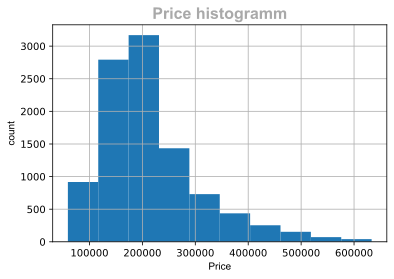

In [59]:
plt.figure(figsize=(6,4))
df_train['Price'].hist()  

plt.title('Price histogramm', fontdict=title_font)
plt.ylabel('count', fontdict=label_font)
plt.xlabel('Price', fontdict=label_font)

plt.show()

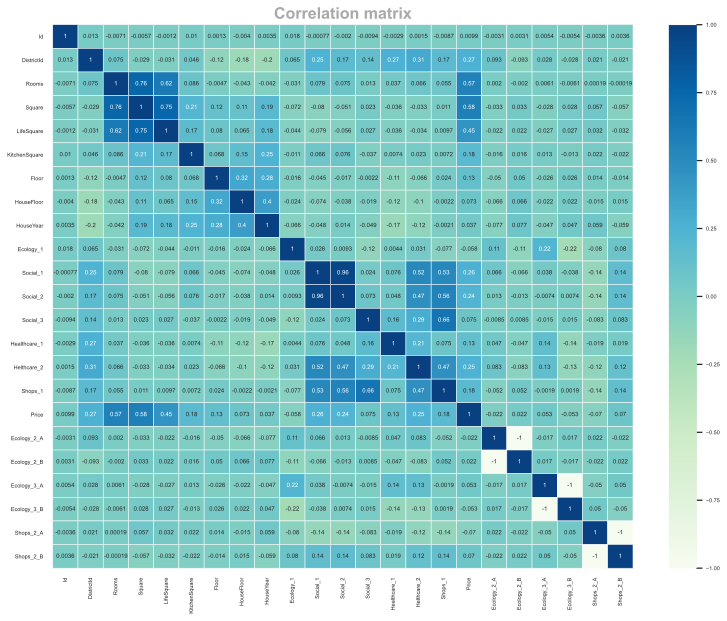

In [60]:
plt.figure(figsize = (13,10))

sns.set(font_scale=0.5)
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix', fontdict=title_font)

plt.show()

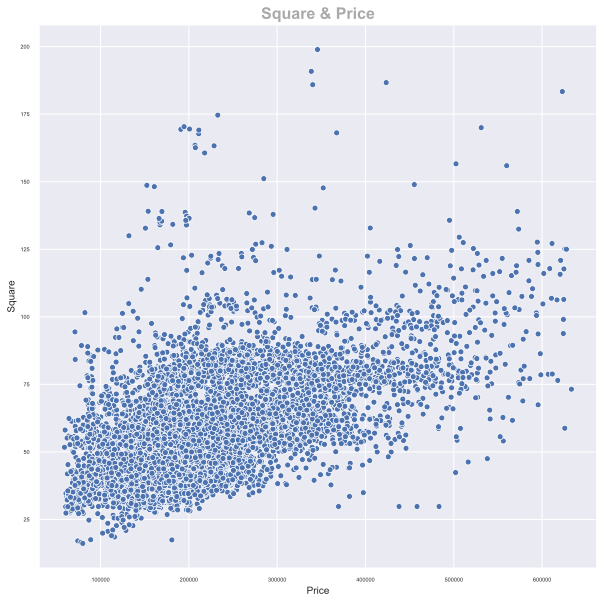

In [61]:
plt.figure(figsize=(10,10))

sns.scatterplot(x=df_train['Price'], y=df_train['Square'])

plt.title('Square & Price', fontdict=title_font)
plt.ylabel('Square', fontdict=label_font)
plt.xlabel('Price', fontdict=label_font)

plt.show()

### Стандартизирую признаки

In [62]:
from sklearn.preprocessing import StandardScaler

#### Обучающий датасет

In [63]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
Ecology_2_A        uint8
Ecology_2_B        uint8
Ecology_3_A        uint8
Ecology_3_B        uint8
Shops_2_A          uint8
Shops_2_B          uint8
dtype: object

In [64]:
columns_for_stand = df_train.columns[:19]

In [65]:
columns_for_stand = df_train[columns_for_stand].select_dtypes(include=['float64', 'int64']).columns.tolist()
columns_for_stand

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

In [66]:
scaler = StandardScaler()
standard_features = scaler.fit_transform(df_train[columns_for_stand])

In [67]:
df_train_scaled = df_train.copy()
df_train_scaled[columns_for_stand] = pd.DataFrame(standard_features, columns=columns_for_stand)

In [68]:
df_train_scaled.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,1.163789,-0.353348,0.133640,-0.434791,-0.388014,-0.424799,-0.291306,-0.571997,-0.861770,-0.250529,B,B,0.474169,0.654880,-0.127533,-0.169240,-0.883480,1.408356,B,184966.930730,0,1,0,1,0,1
1,1.372690,-0.215687,1.352982,0.503350,0.357357,0.087872,-0.291306,-0.571997,-0.372921,-0.998053,B,B,1.215681,1.237169,-0.295384,-1.053217,-0.213923,2.448700,B,300009.450063,0,1,0,1,0,1
2,-0.744716,0.059635,0.133640,-0.595561,-0.405240,-0.424799,-0.100498,-0.092080,-0.916087,-0.581588,B,B,0.531208,0.600720,-0.337347,-1.067950,-0.213923,-0.256195,B,220925.908524,0,1,0,1,0,1
3,-0.529847,0.174352,0.133640,-0.150127,1.248556,0.344207,-0.100498,0.707781,-0.427238,2.680470,B,B,-0.096225,0.095553,-0.211458,0.077202,-0.883480,0.159943,B,175616.227217,0,1,0,1,0,1
4,0.493868,1.115034,-1.085702,-0.876374,-0.786221,-0.168464,0.471924,-0.092080,-0.481554,-0.894969,B,B,0.588247,0.105786,-0.295384,1.408526,0.455633,-0.048126,B,150226.531644,0,1,0,1,0,1


In [69]:
df_train_scaled.std()

Id                   1.000050
DistrictId           1.000050
Rooms                1.000050
Square               1.000050
LifeSquare           1.000050
KitchenSquare        1.000050
Floor                1.000050
HouseFloor           1.000050
HouseYear            1.000050
Ecology_1            1.000050
Social_1             1.000050
Social_2             1.000050
Social_3             1.000050
Healthcare_1         1.000050
Helthcare_2          1.000050
Shops_1              1.000050
Price            92872.293865
Ecology_2_A          0.098015
Ecology_2_B          0.098015
Ecology_3_A          0.163543
Ecology_3_B          0.163543
Shops_2_A            0.275139
Shops_2_B            0.275139
dtype: float64

#### Тестовый датасет

In [70]:
standard_features_test = scaler.fit_transform(df_test[columns_for_stand])

In [71]:
df_test_scaled = df_test.copy()
df_test_scaled[columns_for_stand] = pd.DataFrame(standard_features_test, columns=columns_for_stand)

In [72]:
df_test_scaled.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,-1.590913,0.152140,0.113827,-0.350686,-0.120574,-0.406043,-0.480057,0.259012,-0.667299,1.585280,B,B,-0.794834,-0.660397,-0.304366,-0.168811,-0.891612,-0.888194,B,0,1,0,1,0,1
1,1.540379,0.514336,0.113827,0.681349,-0.156424,-0.406043,-0.480057,-1.132363,-0.398066,-0.367283,B,B,-1.080052,-0.986014,-0.220549,-0.168811,-0.891612,-0.469511,B,0,1,0,1,0,1
2,-0.606887,3.140252,-1.120741,-1.431355,-1.355216,1.256703,-1.209627,-1.132363,-4.059632,-0.998468,B,B,0.288994,0.529306,3.299785,4.791278,2.487242,0.158513,B,0,1,0,1,0,1
3,1.500645,-0.096869,0.113827,0.882820,1.186343,0.425330,2.438224,1.495791,1.217331,-0.149940,B,B,-0.110311,-0.204634,-0.220549,-0.168811,1.135700,-0.260169,B,0,1,0,1,0,1
4,1.213198,-0.549613,-1.120741,-0.476120,0.582367,-0.406043,1.526261,0.722804,1.755796,-0.397445,B,B,-1.308227,-1.186699,-0.304366,-0.168811,-0.891612,-0.888194,A,0,1,0,1,1,0


In [73]:
df_test_scaled.std()

Id               1.000100
DistrictId       1.000100
Rooms            1.000100
Square           1.000100
LifeSquare       1.000100
KitchenSquare    1.000100
Floor            1.000100
HouseFloor       1.000100
HouseYear        1.000100
Ecology_1        1.000100
Social_1         1.000100
Social_2         1.000100
Social_3         1.000100
Healthcare_1     1.000100
Helthcare_2      1.000100
Shops_1          1.000100
Ecology_2_A      0.097518
Ecology_2_B      0.097518
Ecology_3_A      0.170052
Ecology_3_B      0.170052
Shops_2_A        0.275001
Shops_2_B        0.275001
dtype: float64

### Удаляю object-признаки

#### Обучающий датасет

In [74]:
feature_names = df_train_scaled[df_train.columns].select_dtypes(include=['float64', 'int64', 'uint8']).columns.tolist()
feature_names

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [75]:
df_train_prepared = df_train_scaled[feature_names]
df_train_prepared.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,1.163789,-0.353348,0.133640,-0.434791,-0.388014,-0.424799,-0.291306,-0.571997,-0.861770,-0.250529,0.474169,0.654880,-0.127533,-0.169240,-0.883480,1.408356,184966.930730,0,1,0,1,0,1
1,1.372690,-0.215687,1.352982,0.503350,0.357357,0.087872,-0.291306,-0.571997,-0.372921,-0.998053,1.215681,1.237169,-0.295384,-1.053217,-0.213923,2.448700,300009.450063,0,1,0,1,0,1
2,-0.744716,0.059635,0.133640,-0.595561,-0.405240,-0.424799,-0.100498,-0.092080,-0.916087,-0.581588,0.531208,0.600720,-0.337347,-1.067950,-0.213923,-0.256195,220925.908524,0,1,0,1,0,1
3,-0.529847,0.174352,0.133640,-0.150127,1.248556,0.344207,-0.100498,0.707781,-0.427238,2.680470,-0.096225,0.095553,-0.211458,0.077202,-0.883480,0.159943,175616.227217,0,1,0,1,0,1
4,0.493868,1.115034,-1.085702,-0.876374,-0.786221,-0.168464,0.471924,-0.092080,-0.481554,-0.894969,0.588247,0.105786,-0.295384,1.408526,0.455633,-0.048126,150226.531644,0,1,0,1,0,1


#### Тестовый датасет

In [76]:
df_test_prepared = df_test_scaled.loc[:, (df_test_scaled.columns != 'Ecology_2') & (df_test_scaled.columns != 'Ecology_3') & (df_test_scaled.columns != 'Shops_2')]
df_test_prepared.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,-1.590913,0.152140,0.113827,-0.350686,-0.120574,-0.406043,-0.480057,0.259012,-0.667299,1.585280,-0.794834,-0.660397,-0.304366,-0.168811,-0.891612,-0.888194,0,1,0,1,0,1
1,1.540379,0.514336,0.113827,0.681349,-0.156424,-0.406043,-0.480057,-1.132363,-0.398066,-0.367283,-1.080052,-0.986014,-0.220549,-0.168811,-0.891612,-0.469511,0,1,0,1,0,1
2,-0.606887,3.140252,-1.120741,-1.431355,-1.355216,1.256703,-1.209627,-1.132363,-4.059632,-0.998468,0.288994,0.529306,3.299785,4.791278,2.487242,0.158513,0,1,0,1,0,1
3,1.500645,-0.096869,0.113827,0.882820,1.186343,0.425330,2.438224,1.495791,1.217331,-0.149940,-0.110311,-0.204634,-0.220549,-0.168811,1.135700,-0.260169,0,1,0,1,0,1
4,1.213198,-0.549613,-1.120741,-0.476120,0.582367,-0.406043,1.526261,0.722804,1.755796,-0.397445,-1.308227,-1.186699,-0.304366,-0.168811,-0.891612,-0.888194,0,1,0,1,1,0


### Разбиваю обучающий датасет на train и valid

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X = df_train_prepared.loc[:, df_train_prepared.columns != 'Price']
y = df_train_prepared.loc[:, df_train_prepared.columns == 'Price']

In [79]:
print(f'Признаки датасета X:\t{X.columns}')

Признаки датасета X:	Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_A',
       'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B'],
      dtype='object')


In [80]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=27)

### Обучаю модель GradientBoostingRegressor

In [81]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

In [82]:
def r2_score(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n")
    
    plt.figure(figsize=(10,10))
    
    plt.scatter(pred_values, true_values)
   
    plt.title('True vs Predicted values', fontdict=title_font)
    plt.xlabel('Predicted values', fontdict=label_font)
    plt.ylabel('True values', fontdict=label_font)
        
    plt.show()
    return None

In [83]:
final_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=27)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=27)

R2:	0.9



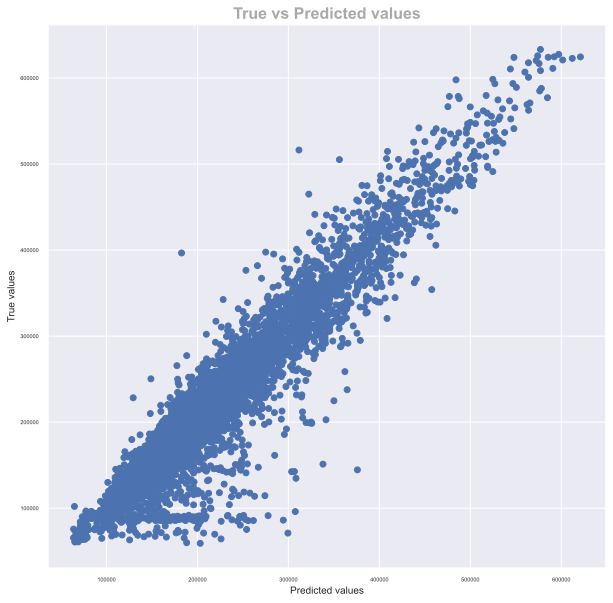

In [84]:
y_train_preds = final_model.predict(X_train)
r2_score(y_train, y_train_preds)

R2:	0.749



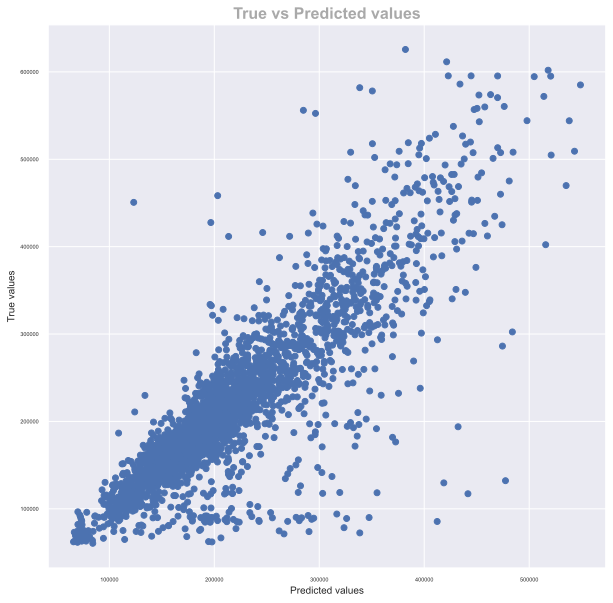

In [85]:
y_valid_preds = final_model.predict(X_valid)
r2_score(y_valid, y_valid_preds)

### Делаю предсказание на тестовом датасете

In [86]:
test_preds = final_model.predict(df_test_prepared)

##### Поле `Id` и предсказанное поле `Price` представляю в виде датасета

In [87]:
predict_price = pd.DataFrame(df_test['Id'])

In [88]:
predict_price['Price'] = test_preds

In [89]:
print(f'Форма массива с предсказанной ценой:\t{predict_price.shape}')

Форма массива с предсказанной ценой:	(5000, 2)


In [90]:
predict_price.head(10)

,Id,Price
0,725,149119.573238
1,15856,203919.603396
2,5480,170422.081658
3,15664,381661.687183
4,14275,142085.734418
5,7633,195143.217156
6,13329,169079.561887
7,5502,211842.511039
8,4220,325324.202168
9,11538,201790.291337


### Сохраняю получившийся датасет в файл .csv

In [91]:
predict_price.to_csv(PREDICT_PRICE_PATH, index=False, encoding='utf-8')